In [1]:
import numpy as np
import scipy.signal
from scipy.signal import butter, filtfilt, deconvolve
import scipy.io as sio
from scipy.stats.stats import zscore
from scipy import ndimage
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import gridspec
from matplotlib.patches import Ellipse
%matplotlib inline

import pyret.spiketools as spk
import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.visualizations as viz
import pyret.nonlinearities as nl

import h5py
import warnings

import pylab
from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0)



In [39]:
from os import listdir
from os.path import isfile, join

In [45]:
# 2019 0129 David data open


'/Users/peterfish/Modules/1d_wn_amacrine_DL'

In [84]:
# all h5 files:
data_dir = '/Users/peterfish/Modules/1d_wn_amacrine_DL/data/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
files = [f for f in files if '.h5' in f]
files

['18-03-23-r1-c2-1-line.h5',
 '18-03-13-r3-c2-1-line.h5',
 '17-11-07-r1-c5-1-line.h5',
 '17-10-20-r1-c4-1-line.h5',
 '17-11-08-r1-c5-1-line.h5',
 '17-07-03-r1-c6-1-line.h5',
 '17-11-06-r1-c1-1-line.h5',
 '17-10-26-r2-c3-1-line.h5',
 '17-11-14-r1-c8-1-line.h5',
 '18-04-23-r1-c8-1-line.h5',
 '17-10-26-r1-c1-1-line.h5',
 '17-10-18-r1-c5-1-line.h5']

In [65]:
#date = '17-11-08'
#retina_num = 1
#cell_num = 5

### Rarely change
fine_name_i_rf_line = date + '-r' + str(retina_num) + '-c' + str(cell_num) + '-1-line.h5'


frame_num_rf_30m = 54000
kernel_length_rf = 0.5 # in [s]
upsample_factor_g_rf = 4

#
frame_num_bar_25r = 26100
frame_time = 0.01666574578544061
up_sampling = 16

repeat_time = 23 # roughly takes 18[s] for each repeat (8 trials)
sigma_fr = 0.01

gain = 0.000152587890625
#gain = np.double(f['data'].attrs['gain'])
offset = 0
threshold_intra_rf_line = 0.9
sample_rate = 10000.0

In [66]:
order_l = 4 
order_h = 3
cutoff_l = 15      # desired cutoff frequency of the lowpass filter, [Hz]
cutoff_h = 0.04

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b_l, a_l = butter(order, normal_cutoff, btype='low', analog=False)
    return b_l, a_l

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b_l, a_l = butter_lowpass(cutoff, fs, order=order)
    y_l = filtfilt(b_l, a_l, data)
    # filtfilt is to compensate delay introduced by this lowpass filter
    return y_l

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b_h, a_h = butter(order, normal_cutoff, btype='high', analog=False)
    return b_h, a_h

def butter_highpass_filter(data, cutoff, fs, order=5):
    b_h, a_h = butter_highpass(cutoff, fs, order=order)
    y_h = filtfilt(b_h, a_h, data)
    return y_h

In [8]:
# Load file
f_intra_rf_line = h5py.File(data_dir + fine_name_i_rf_line, 'r')
pd_intra_rf_line = np.double(f_intra_rf_line['data'][0, :])
pd_intra_rf_line = pd_intra_rf_line - np.min(pd_intra_rf_line)
pd_intra_rf_line = pd_intra_rf_line / np.max(pd_intra_rf_line)
maxtab_intra_rf_line, mintab_intra_rf_line = spk.peakdet(pd_intra_rf_line, threshold_intra_rf_line)
print(maxtab_intra_rf_line, '\n', len(maxtab_intra_rf_line))
volt_intra_rf_line = (-np.double(f_intra_rf_line['data'][1, :]) * gain - offset) * 0.1 * 1000 # [mV]
f_intra_rf_line.close()

[[  7.00000000e+00   9.71698113e-01]
 [  1.75000000e+02   9.97097242e-01]
 [  1.49992200e+06   1.00000000e+00]] 
 3


## Stim data

In [67]:
# Load stimulus
stim_dir = '/Users/peterfish/Modules/1d_wn_amacrine_DL/'
stim_filename = 'lineColor_w4.mat'
f_stim_rf_line = sio.loadmat(stim_dir + stim_filename)
stim_intra_rf_line = np.array(f_stim_rf_line['lineColor'])[0, :, :4500]
## [0, :, :4500]??
stim_intra_rf_line = np.reshape(stim_intra_rf_line, [64, 4500])       
stim_intra_rf_line = np.einsum('ij->ji', stim_intra_rf_line)
stim_intra_rf_line.shape

(4500, 64)

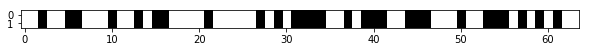

In [68]:
imshow(np.vstack((stim_intra_rf_line[0, :], stim_intra_rf_line[0, :])), cmap='gray')
# vstack?? 2 identical lines. (1 line is too thin..)

In [69]:
# normalize the stimulus 
stim_intra_rf_line = zscore(stim_intra_rf_line)
# upsampling
stim_intra_rf_line_us = st.upsample(stim_intra_rf_line, up_sampling)[0]
# zscore again?
stim_intra_rf_line_us_input = zscore(stim_intra_rf_line_us)

In [63]:
a = np.linspace(1, 10, 10)
print(a)
a[-3]

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


8.0

## Recording data

In [79]:
len(files)

12

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


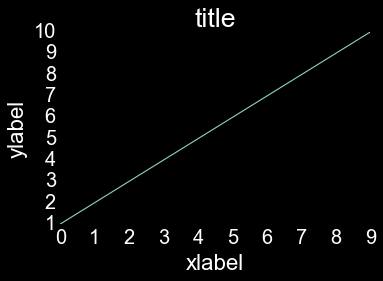

In [149]:
plt.rcParams['figure.figsize'] = [5, 3]
# plot style test
print(plt.style.available)
#plt.style.use(['classic'])
plt.style.use(['seaborn-dark','dark_background'])
# plt.style.use('seaborn-dark') # Working in dark theme jupyter lab. Figures for white presentation
#
plt.rcParams['font.size'] = 20
#plt.rcParams['axes.labelsize'] = 40
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
#
a = np.linspace(1, 10, 10)
plt.plot(a)
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('title')
# etc
#ax2.xaxis.grid()
#ax2.set_xlim([0,n_data_res])
#ax2.set_yticklabels([])
plt.show()

In [144]:
keys = ['resp']
values 
data = [dict(zip(keys, values)) for c in range(n_cell)]

72000

In [167]:
# Create a list of ditionaries with just cell id? Then, I can add more fields in a flexible way?
thisdic = { 
"cell id": 1,
"test": "asdf"
}
thisdic["newkey"] = 3
print(thisdic)
l = [thisdic for c in range(3)]
print(l)

{'cell id': 1, 'test': 'asdf', 'newkey': 3}
[{'cell id': 1, 'test': 'asdf', 'newkey': 3}, {'cell id': 1, 'test': 'asdf', 'newkey': 3}, {'cell id': 1, 'test': 'asdf', 'newkey': 3}]


In [170]:
#l[1]["newkey"] = np.linspace(1, 10, 10)
l[1]["newkey"] = 5
print(l[1])
print(l)

{'cell id': 1, 'test': 'asdf', 'newkey': 5}
[{'cell id': 1, 'test': 'asdf', 'newkey': 5}, {'cell id': 1, 'test': 'asdf', 'newkey': 5}, {'cell id': 1, 'test': 'asdf', 'newkey': 5}]


In [178]:
listdic = [dict() for c in range(3)]
print(listdic)
listdic[0]['f'] = 1
listdic[0]['g'] = 3
listdic[1]['f'] = 'asdf'
listdic[2]['f'] = np.linspace(1, 5, 5)
print(listdic)

[{}, {}, {}]
[{'f': 1, 'g': 3}, {'f': 'asdf'}, {'f': array([ 1.,  2.,  3.,  4.,  5.])}]


File id: 1 (18-03-23-r1-c2-1-line.h5)


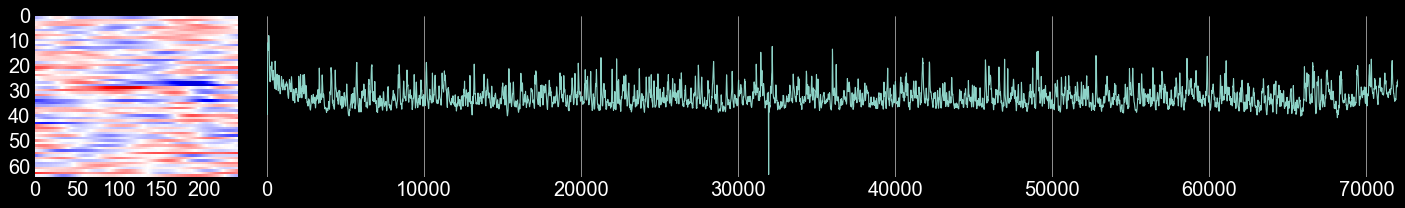

File id: 2 (18-03-13-r3-c2-1-line.h5)


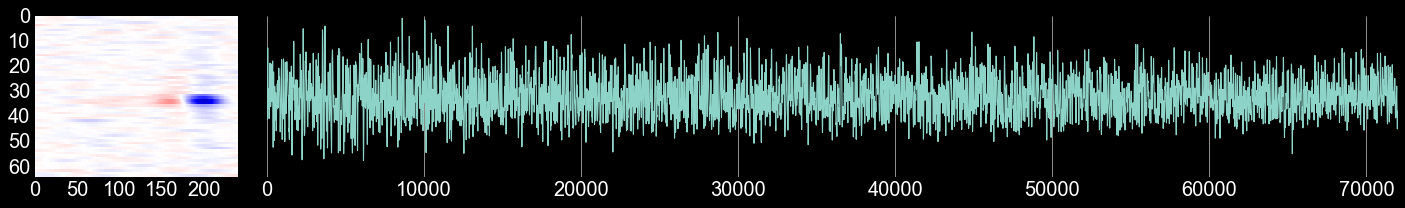

File id: 3 (17-11-07-r1-c5-1-line.h5)


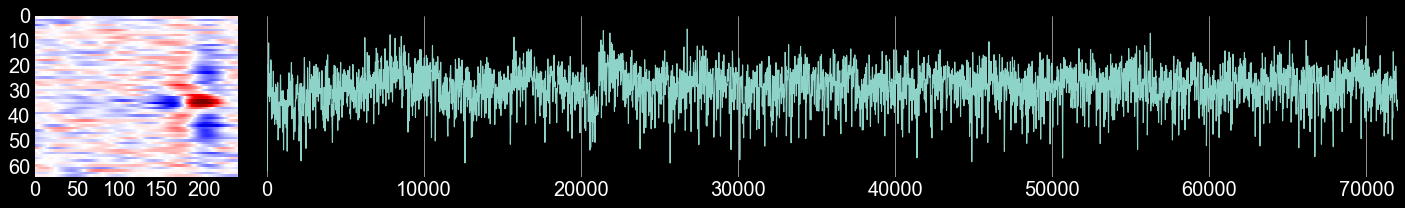

File id: 4 (17-10-20-r1-c4-1-line.h5)


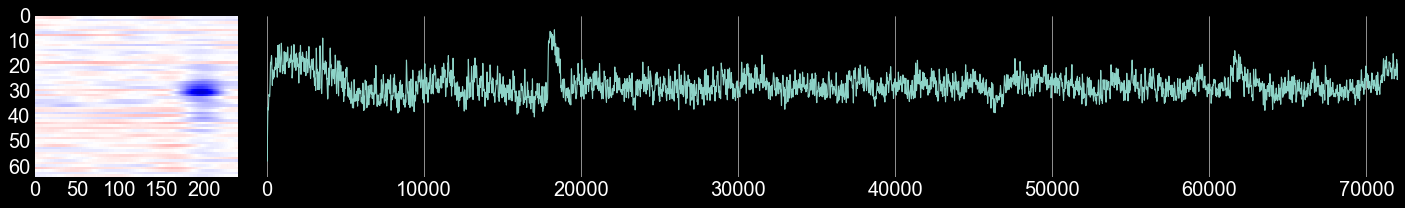

File id: 5 (17-11-08-r1-c5-1-line.h5)


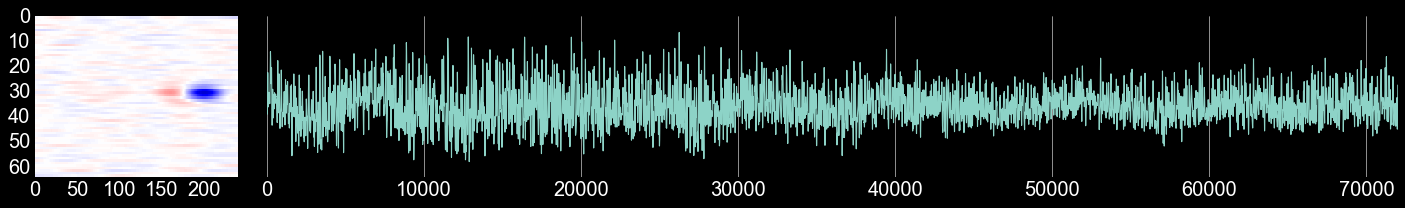

File id: 6 (17-07-03-r1-c6-1-line.h5)


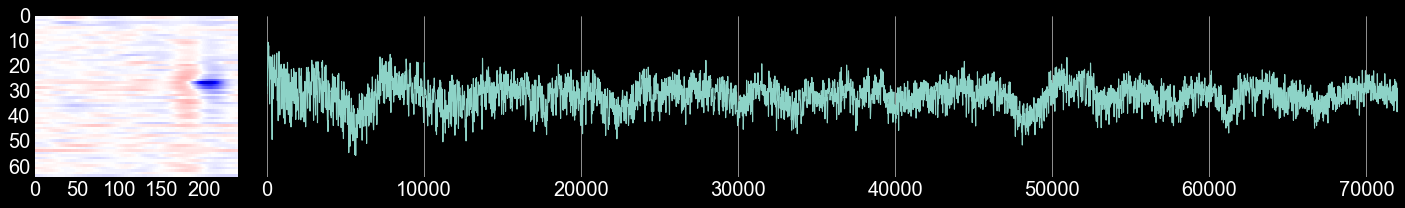

File id: 7 (17-11-06-r1-c1-1-line.h5)


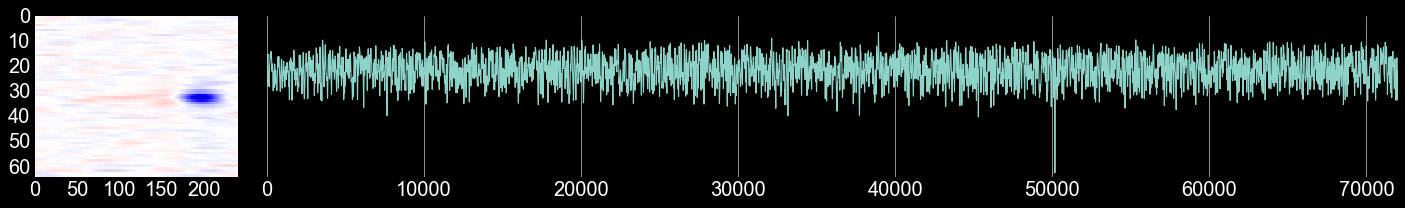

File id: 8 (17-10-26-r2-c3-1-line.h5)


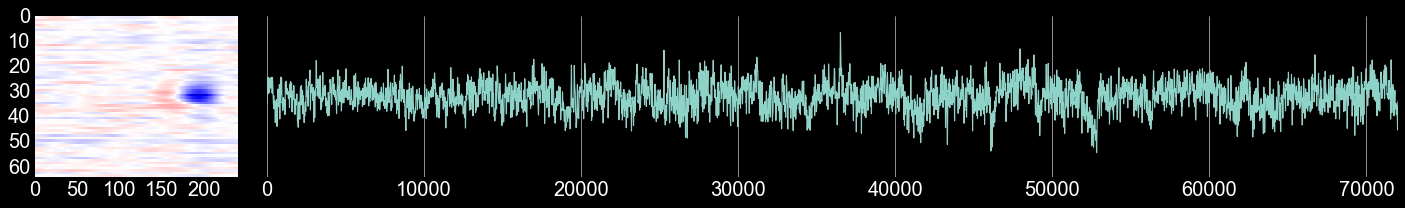

File id: 9 (17-11-14-r1-c8-1-line.h5)


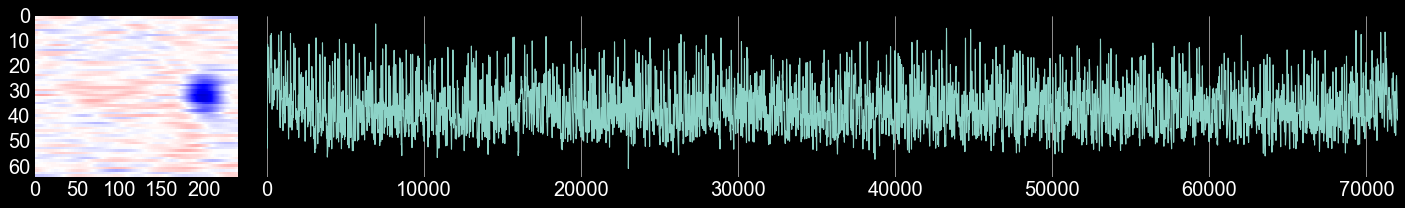

File id: 10 (18-04-23-r1-c8-1-line.h5)


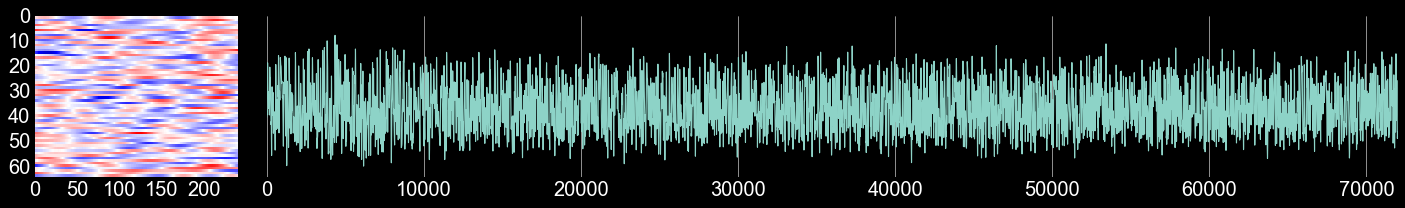

File id: 11 (17-10-26-r1-c1-1-line.h5)


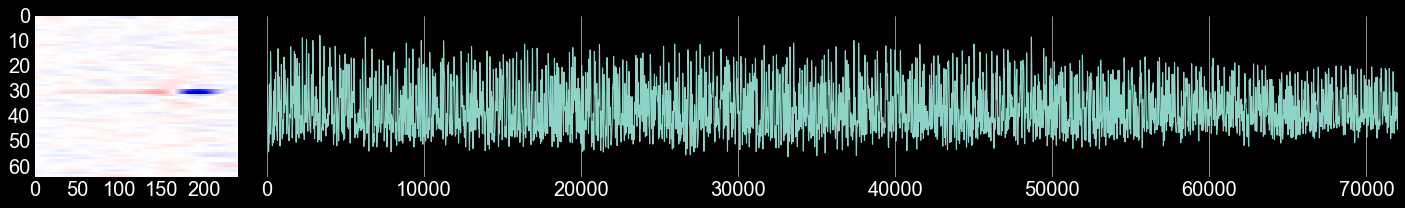

File id: 12 (17-10-18-r1-c5-1-line.h5)


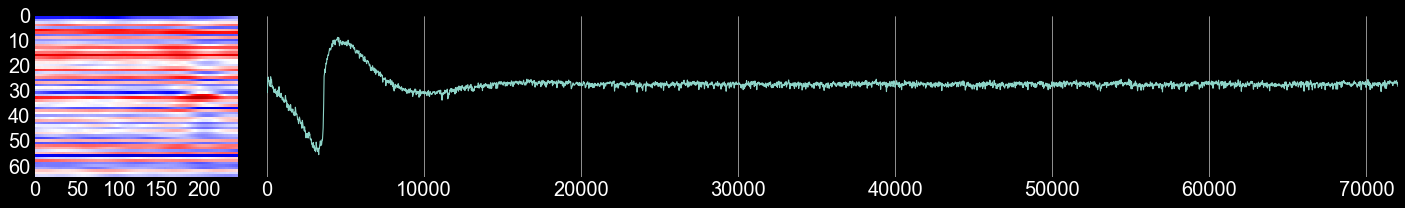

In [191]:
# Load all recording data files
n_cell = len(files)
data = [dict() for c in range(n_cell)]
ignorebefore = 100
# plot properties
n_subplots = 6 

for i in range(n_cell):
    filename = data_dir+files[i]
    with h5py.File(filename, 'r') as f:
        #print("Keys: %s" % f.keys())
        fig = plt.figure(figsize=(18, 3))
        #ax1 = plt.subplot(1, n_subplots, 1)
        #ax2 = plt.subplot(1, n_subplots, 3)
        ax1 = plt.subplot2grid((1, n_subplots), (0,0), colspan=1)
        ax2 = plt.subplot2grid((1, n_subplots), (0,1), colspan=n_subplots-1)

        # Get PD signal and center it.
        pd_intra_rf_line = np.double(f['data'][0, :])
        pd_intra_rf_line = pd_intra_rf_line - np.min(pd_intra_rf_line)
        pd_intra_rf_line = pd_intra_rf_line / np.max(pd_intra_rf_line)
        # Peak detection
        maxtab_intra_rf_line, mintab_intra_rf_line = spk.peakdet(pd_intra_rf_line, threshold_intra_rf_line)
        #print(maxtab_intra_rf_line, '\n', len(maxtab_intra_rf_line))
        
        # Get Vol signal (2nd channel)
        volt_intra_rf_line = (-np.double(f['data'][1, :]) * gain - offset) * 0.1 * 1000 # [mV]
        # raw data plot
        #ax2.plot(volt_intra_rf_line)
        
        # end-data floating error handling
        volt_intra_rf_line[-10100:] = np.ones(volt_intra_rf_line[-10100:].shape[0]) * volt_intra_rf_line[-10100]
        
        # filtering
        volt_intra_rf_line_hf = butter_highpass_filter(volt_intra_rf_line, cutoff_h, sample_rate, order_h)
        volt_intra_rf_line_hf_lf = butter_lowpass_filter(volt_intra_rf_line_hf, cutoff_l, sample_rate, order_l)
        
        # down-sampling & resampling
        volt_intra_rf_line_ds = st.downsample(volt_intra_rf_line_hf_lf[np.int(maxtab_intra_rf_line[0, 0]):
                                                               np.int(maxtab_intra_rf_line[2, 0])], 10)[0]
        volt_intra_rf_line_ds_rs = scipy.signal.resample(volt_intra_rf_line_ds, stim_intra_rf_line_us.shape[0])
        # data centering
        #volt_intra_rf_line_ds_rs_output = volt_intra_rf_line_ds_rs - np.mean(volt_intra_rf_line_ds_rs) # mean substraction by DL
        volt_intra_rf_line_ds_rs_output = zscore(volt_intra_rf_line_ds_rs)
        vol_resampled_centered = zscore(volt_intra_rf_line_ds_rs)
        #
        n_data_res = len(vol_resampled_centered)
        #
        print('File id: %d (%s)' % (i+1, files[i]))

        # Plot the filtered, resampled trace.
        ax2.plot(vol_resampled_centered)
        ax2.set_xlim([0,n_data_res])
        ax2.xaxis.grid()
        ax2.set_yticklabels([])
        
        # ignore until 100 time points?
        stim = stim_intra_rf_line_us_input[ignorebefore:n_data_res]
        resp = vol_resampled_centered[ignorebefore:n_data_res]
        data[i]['resp'] = resp
        rc_line, rags_line = ft.revcorr(stim, resp, 300)
        #
        frame_line_500ms = np.int((0.5 / (rags_line.shape[0] * frame_time/8)) * rags_line.shape[0])
        #
        im = ax1.imshow(rc_line[-frame_line_500ms:].T, cmap='seismic', interpolation='nearest', 
                       vmin=1.6*np.min(rc_line), vmax=-1.6*np.min(rc_line), aspect='auto')
        cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontname='Arial', fontsize=12)
        ax1.axis('off')
        plt.tight_layout()
        plt.show()
        # save to npy file
        #np.save('cell_id_%d__resp_' % i + files[i] + '.npy' , resp)
        

In [194]:
# Save resampled trace as npy
# Cell id from 1 (i+1) to ...
for i in range(n_cell):
    np.save( data_dir+'cell__%03d__resp_' % (i+1) + files[i] + '.npy' , data[i]['resp'])

In [ ]:
# Temporal filters: Who has a biphasic filter?

In [14]:
volt_intra_rf_line[-10100:] = np.ones(volt_intra_rf_line[-10100:].shape[0]) * volt_intra_rf_line[-10100]

In [15]:
volt_intra_rf_line_hf = butter_highpass_filter(volt_intra_rf_line, cutoff_h, sample_rate, order_h)
volt_intra_rf_line_hf_lf = butter_lowpass_filter(volt_intra_rf_line_hf, cutoff_l, sample_rate, order_l)

In [16]:
volt_intra_rf_line_ds = st.downsample(volt_intra_rf_line_hf_lf[np.int(maxtab_intra_rf_line[0, 0]):
                                                               np.int(maxtab_intra_rf_line[2, 0])], 10)[0]
volt_intra_rf_line_ds_rs = scipy.signal.resample(volt_intra_rf_line_ds, stim_intra_rf_line_us.shape[0])
volt_intra_rf_line_ds_rs_output = volt_intra_rf_line_ds_rs - np.mean(volt_intra_rf_line_ds_rs)

In [30]:
# ignore until 100 time points?
stim = stim_intra_rf_line_us_input[100:72000]
resp = volt_intra_rf_line_ds_rs_output[100:72000]

#rc_line, rags_line = ft.revcorr(stim_intra_rf_line_us_input[100:72000], volt_intra_rf_line_ds_rs_output[100+300-1:72000], 300)
# For pyret 0.6.0 (Juyoung)
rc_line, rags_line = ft.revcorr(stim_intra_rf_line_us_input[100:72000], volt_intra_rf_line_ds_rs_output[100:72000], 300)
#rc_line = rc_line - np.mean(rc_line, axis=0)

In [32]:
frame_line_500ms = np.int((0.5 / (rags_line.shape[0] * frame_time/8)) * rags_line.shape[0])

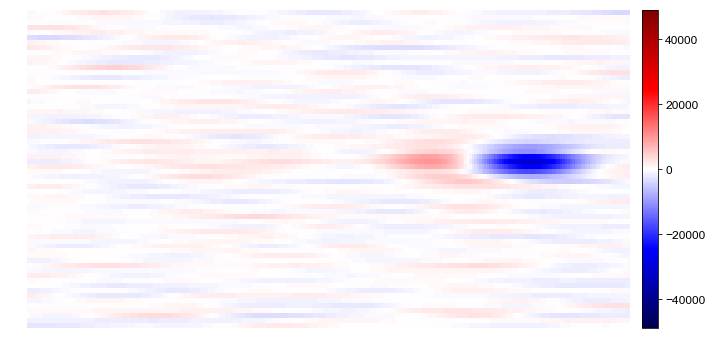

In [33]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
im = ax.imshow(rc_line[-frame_line_500ms:].T, cmap='seismic', interpolation='nearest', 
               vmin=1.6*np.min(rc_line), vmax=-1.6*np.min(rc_line), aspect='auto')
cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontname='Arial', fontsize=12)
ax.axis('off')
plt.tight_layout()

In [35]:
# save
np.save(fine_name_i_rf_line+'_resp'+'.npy', resp);
np.save(fine_name_i_rf_line+'_stim'+'.npy', stim);
np.save('resp.npy', resp);
np.save('stim.npy', stim);